In [1]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

In [3]:
token = os.environ.get("INFLUXDB_TOKEN")
bucket = os.environ.get("INFLUXDB_BUCKET")
org = os.environ.get("INFLUXDB_ORG")
url = os.environ.get("INFLUXDB_URL")
client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
write_api = client.write_api(write_options=SYNCHRONOUS)
df = pd.DataFrame()


In [ ]:
industries = {
    "AAPL": "Technology",
    "MSFT": "Technology",
    "GOOGL": "Technology",
    "NFLX": "Entertainment",
    "DIS": "Entertainment",
    "AMZN": "E-Commerce",
    "TSLA": "Automotive",
    "MBG.DE": "Automotive",
    "BMW.DE": "Automotive",
    "META": "Social Media",
}

In [ ]:
def get_data(tickers, start_date, end_date):
    global df
    df = yf.download(tickers, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df.rename(columns={'Date': 'time'}, inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = df['time'].dt.tz_localize('UTC')
    df.set_index('time', inplace=True)


In [ ]:
def write_ticker(ticker:str):
   dat = yf.Ticker(ticker)
   history = dat.history(period="20y")
   for index, row in history.iterrows():
    point = (
        Point("stock_history")
        .tag("ticker", ticker)
        .tag("industry", industries.get(ticker, "Unknown"))
        .field("open", row["Open"])
        .field("high", row["High"])
        .field("low", row["Low"])
        .field("close", row["Close"])
        .field("volume", row["Volume"])
        .time(index, WritePrecision.NS)
    )

    write_api.write(bucket=bucket, org=org, record=point)

In [6]:
write_ticker("AAPL")

In [7]:
write_ticker("MSFT")

In [8]:
write_ticker("NFLX")

In [9]:
query_api = client.query_api()

query = """from(bucket: "my-bucket")
 |> range(start: -5y)
 |> filter(fn: (r) => r._measurement == "stock_history")
 |> filter(fn: (r) => r._field == "close")"""

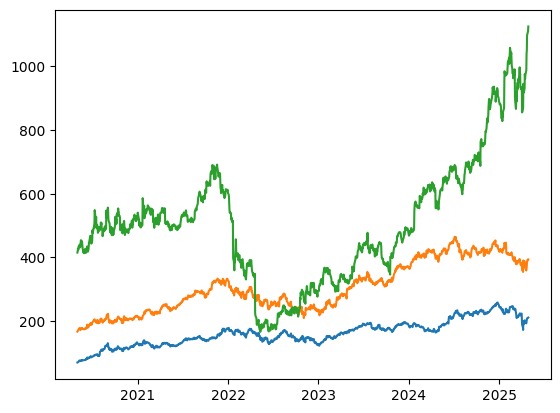

In [10]:
tables = query_api.query(query, org=org)
for table in tables:
    plt.plot([record.get_time() for record in table.records], [record.get_value() for record in table.records], label=table.records[0]["ticker"])

In [12]:
ftw_query = """from(bucket: "my-bucket")
|> range(start: -52w)
|> filter(fn: (r) => r._measurement == "stock_history")
|> filter(fn: (r) => r._field == "close")
"""
ftw_high_query = ftw_query + "|> max()"



ftw_low_query =  ftw_query + "|> min()"

ftw_low_high_query = f"""minimum = {ftw_low_query}

maximum = {ftw_high_query}

union(tables: [minimum, maximum])"""

ftw_low_high_tables = query_api.query(ftw_low_high_query, org=org)
for table in ftw_low_high_tables:
    ticker = table.records[0]["ticker"]
    low = table.records[0].get_value()
    high = table.records[1].get_value()
    print(f"{ticker} 52-Wochen...\n\tTief: {low}\n\tHoch: {high}")

print("52w-Hoch für...")
ftw_high_tables = query_api.query(ftw_high_query, org=org)
for table in ftw_high_tables:
    for record in table.records: # should only iterate once
        record.get_start()
        print(f"\t...{record['ticker']} {record.get_value()}")




AAPL 52-Wochen...
	Tief: 172.21682739257812
	Hoch: 258.7355041503906
MSFT 52-Wochen...
	Tief: 354.55999755859375
	Hoch: 464.8543395996094
NFLX 52-Wochen...
	Tief: 565.1500244140625
	Hoch: 1125.6400146484375
52w-Hoch für...
	...AAPL 258.7355041503906
	...MSFT 464.8543395996094
	...NFLX 1125.6400146484375


Diese Punkte lassen sich auch in der zuvorgesehenen Abbildungen einzeichenen. Dabei Stellen sie nicht das Allgemeine Minimum und Maximum dar, da der Graph für einen längeren Zeitraum als 52 Wochen verläuft.

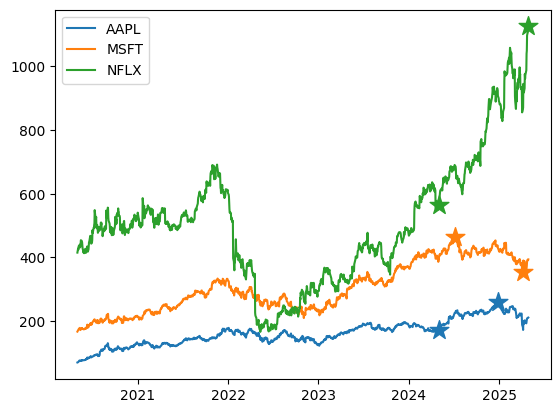

In [13]:
for table in tables:
    plt.plot([record.get_time() for record in table.records], [record.get_value() for record in table.records], label=table.records[0]["ticker"])
for table in ftw_low_high_tables:
    plt.scatter(
        [record.get_time() for record in table.records],
        [record.get_value() for record in table.records],
        marker="*",
        s=200
    )
plt.legend()